# Colombian Newspaper analyis: A network science analysis

This report aims to analyze a Colombian newspaper news through network science. We conduct a textual analysis of approximately 90 articles, equally distributed among the topics of politics, education, and technology. By using co-occurrence networks, we map out conceptual associations within the articles to visually represent the typical connections made by the newspaper’s journalists. This approach allows us to illustrate El Tiempo’s editorial slant through graphical representations of the networked concepts.

The data was gathered manually from news sources in 2024. We'll try to draw conclusions about the news and potential biases, but there are limitations. These include the limited timeframe, small sample size, and subjective exclusion of certain words. So, the findings may not perfectly reflect reality. Still, we expect this analysis to help identify the main topics and biases in this Colombian newspaper.

#### Dataset
You can find the dataset at[/term_project/data/articles](/term_project/data/articles ) It contains a collection of articles. Here's an example sample:

```json
{
    "title": "Cookies: en que momento es recomendable no aceptarlas? Le contamos",
    "url": "https://www.eltiempo.com/tecnosfera/dispositivos/cookies-en-que-momento-es-recomendable-no-aceptarlas-le-contamos-3336305",
    "category": "tech",
    "content": [
      "Las cookies son fragmentos de texto que los sitios web envian a los navegadores con el fin de recordar la informacion de sus busquedas, lo que le facilita encontrar informacion de su idioma, almacena los articulos que ha anadido a su carrito de compras, entre otros datos.",
}
```

#### Packages

* Data handling
  * Pandas
* Text Processing
  * NLTK
  * Spacy
  * Regex (re)
* Network Analysis
  * Networkx

#### Installation instructions

1) pipenv install
2) pipenv run python -m spacy download es_core_news_lg

# Setup the project


In [1]:
import spacy
import pandas as pd
import json
import nltk
from nltk.corpus import stopwords
import re
from unidecode import unidecode
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community
from data.stop_words import STOP_WORDS

# Load the medium-sized Spanish model
nlp = spacy.load('es_core_news_lg')
# Download NLTK stop words 
nltk.download('stopwords')
# Get stop words for Spanish
spanish_stop_words = stopwords.words('spanish')
spanish_stop_words.extend(STOP_WORDS)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load the data

In [2]:
def load_json_from_path(file_path:str):
    """
    Load JSON data from a file path.

    Parameters:
        file_path (str): The path to the JSON file.

    Returns:
        dict: The JSON data loaded from the file.
    """
    with open(file_path, 'r', encoding="utf8") as file:
        json_data = json.load(file)
    return json_data

In [3]:
articles = load_json_from_path('./data/articles.json')

In [4]:
f'There are {len(articles)} articles'

'There are 88 articles'

In [5]:
articles[0]

{'title': 'Petro y la lucha de clases / Columna de Felipe López Caballero',
 'url': 'https://www.eltiempo.com/politica/gobierno/petro-y-la-lucha-de-clases-columna-de-felipe-lopez-caballero-3333631',
 'category': 'politic',
 'content': ['La explicación está en la narrativa que Petro y sus redes sociales han creado. Según esta: 1) Colombia ha estado gobernada durante 200 años por unas élites corruptas interesadas solamente en enriquecerse y perpetuarse en el poder.',
  '2) Con Petro llegaría el primer presidente de izquierda cuya preocupación son los pobres y la justicia social.',
  '3) Los dueños de Colombia no estarían dispuestos a ceder sus privilegios ante un exguerrillero que busca el cambio.',
  'Esa narrativa es simplista, efectista y dañina. Para comenzar, el problema no es que Petro sea un exguerrillero. Si el presidente fuera Antonio Navarro la economía estaría funcionando mejor y la polarización no estaría disparada. La mitad del estancamiento del PIB obedece a factores intern

# Data cleaning

* **Removing Special Characters**: Characters such as (%,$,#, etc.) do not provide any useful information, so they will be ignored
* **Remove stop words**:  Stop words are common words in a language that are often used to connect sentences or fill gaps in speech, such as  (el,ella, eso,aqui, alla, etc) even These words do not carry significant meaning on their own and are unlikely to contribute to the analysis of the text
* **Apply lemmatization**: Lemmatization is a process where words are reduced to their base or root form. This is particularly useful because some words may have different forms but convey the same concept. For instance, words like (cambio, cambia, cambiará, cambió, cambiaron, etc.) all stem from the same root word, "cambiar" (to change). By lemmatizing these words, we can simplify the data and ensure consistency in representing concepts, leading to more accurate analysis results.



In [6]:
import re
from unidecode import unidecode

def preprocess_text(text):
    
    text = unidecode(text) # Remove accents 
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower()) # Remove punctuation and convert to lowercase

    return text

def remove_stop_words(text, custom_stop_words):
    """
    Remove custom stop words from the input text.

    Args:
        text (str): Input text.
        custom_stop_words (list): List of custom stop words to be removed.

    Returns:
        str: Text with custom stop words removed.
    """
    stop_words = set(custom_stop_words)
    return ' '.join(word for word in text.split() if word.lower() not in stop_words)

def lemmatize(text):
    # Process the text
    doc = nlp(text)
    # Extract the lemma for each token in the text
    lemmas = [token.lemma_ for token in doc]
    return lemmas

* Extract paragraphs from articles and unify them into a single list.

In [7]:
categories = [doc['category'] for doc in articles for para in doc['content']]

In [8]:
doc_id = [id for id, doc in enumerate(articles) for para in doc['content']]

In [9]:
documents = [para for doc in articles for para in doc['content']]

In [10]:
len(categories), len(documents)

(1020, 1020)

In [11]:
list(zip(documents[0:5],categories[0:5], doc_id[0:5]))

[('La explicación está en la narrativa que Petro y sus redes sociales han creado. Según esta: 1) Colombia ha estado gobernada durante 200 años por unas élites corruptas interesadas solamente en enriquecerse y perpetuarse en el poder.',
  'politic',
  0),
 ('2) Con Petro llegaría el primer presidente de izquierda cuya preocupación son los pobres y la justicia social.',
  'politic',
  0),
 ('3) Los dueños de Colombia no estarían dispuestos a ceder sus privilegios ante un exguerrillero que busca el cambio.',
  'politic',
  0),
 ('Esa narrativa es simplista, efectista y dañina. Para comenzar, el problema no es que Petro sea un exguerrillero. Si el presidente fuera Antonio Navarro la economía estaría funcionando mejor y la polarización no estaría disparada. La mitad del estancamiento del PIB obedece a factores internacionales, pero la otra mitad tiene nombre propio. El problema es que Petro, un agitador político brillante, ha resultado un administrador incompetente con una personalidad para

* Apply cleaning

In [12]:
documents_clean = [remove_stop_words(preprocess_text(' '.join(lemmatize(d))),spanish_stop_words) for d in documents]

* Data after cleaning

In [13]:
documents_clean[0:3]

['explicacion narrativa petro red social crear colombia gobernado elite corrupto interesado enriquecer perpetuar',
 'petro presidente izquierda preocupacion pobre justicia social',
 'dueno colombia dispuesto ceder privilegio exguerrillero buscar cambio']

In [14]:
def text_to_network(words: list[str]):
    network_dictionary = []
    limit = len(words) - 3
    for idx, word in enumerate(words):
        if idx == limit:
            break
        network_dictionary.extend(
            [
                {"_from": word, "to": words[idx + 1], "weight": 3},
                {"_from": word, "to": words[idx + 2], "weight": 2},
                {"_from": word, "to": words[idx + 3], "weight": 1},
            ]
        )
    network_dictionary.extend([
        {"_from": words[-3], "to": words[-2], "weight": 3},
        {"_from": words[-3], "to": words[-1], "weight": 2},
        {"_from": words[-2], "to": words[-1], "weight": 3}
    ])
    return network_dictionary


In [15]:
network_dict_dataset = [] 
network_dict_dataset.extend([
    relation | {"category":category} | {"doc_id": doc_id}
    for doc, category,doc_id  in zip(documents_clean, categories,doc_id)
    if len(doc.split()) >= 5
    for relation in text_to_network(doc.split())
])


In [16]:
network_df = pd.DataFrame(network_dict_dataset)

In [17]:
network_df.shape

(49653, 5)

In [18]:
network_df

,_from,to,weight,category,doc_id
0,explicacion,narrativa,3,politic,0
1,explicacion,petro,2,politic,0
2,explicacion,red,1,politic,0
3,narrativa,petro,3,politic,0
4,narrativa,red,2,politic,0
...,...,...,...,...,...
49648,afectar,ciudad,2,education,87
49649,afectar,universitaria,1,education,87
49650,servicio,ciudad,3,education,87
49651,servicio,universitaria,2,education,87


In [19]:
score_network_df = network_df.groupby(['_from','to','category','doc_id']).agg(score=('weight', 'sum')).reset_index()

In [20]:
score_network_df.shape

(47303, 5)

In [21]:
len(score_network_df['_from'].value_counts())

4668

In [22]:
total_scores = score_network_df.groupby('category')['score'].transform('sum')
score_network_df['normalized_score'] = score_network_df['score'] / total_scores
score_network_df['number_of_documents'] = score_network_df.groupby('category')['category'].transform('count')
score_network_df['frequency'] = score_network_df.groupby(['_from','to'])['category'].transform('count')
score_network_df['relation'] = score_network_df['_from'] + '_' + score_network_df['to']
score_network_df.sort_values('score', ascending=False).head(10)

,_from,to,category,doc_id,score,normalized_score,number_of_documents,frequency,relation
45250,universidad,nacional,education,61,33,0.001126,13496,14,universidad_nacional
38473,red,social,tech,40,33,0.000882,17519,18,red_social
15322,educacion,superior,education,59,27,0.000922,13496,4,educacion_superior
13259,desplazamiento,forzado,politic,13,27,0.000782,16288,1,desplazamiento_forzado
27160,map,view,tech,53,24,0.000641,17519,1,map_view
24098,instituto,kroc,politic,17,24,0.000695,16288,1,instituto_kroc
19348,firmante,paz,politic,22,23,0.000666,16288,1,firmante_paz
14778,does,work,education,67,21,0.000717,13496,1,does_work
16411,english,does,education,67,21,0.000717,13496,1,english_does
45249,universidad,nacional,education,60,21,0.000717,13496,14,universidad_nacional


In [23]:
score_network_df['tfidf_score'] = score_network_df['normalized_score']* np.log((score_network_df['number_of_documents'] +1)/( score_network_df['normalized_score']+1))

In [24]:
score_network_df.shape

(47303, 10)

In [25]:
score_network_df.sort_values('tfidf_score', ascending=False).head(10)

,_from,to,category,doc_id,score,normalized_score,number_of_documents,frequency,relation,tfidf_score
45250,universidad,nacional,education,61,33,0.001126,13496,14,universidad_nacional,0.010711
15322,educacion,superior,education,59,27,0.000922,13496,4,educacion_superior,0.008764
38473,red,social,tech,40,33,0.000882,17519,18,red_social,0.008614
13259,desplazamiento,forzado,politic,13,27,0.000782,16288,1,desplazamiento_forzado,0.007585
38339,rector,universidad,education,61,21,0.000717,13496,4,rector_universidad,0.006817
14778,does,work,education,67,21,0.000717,13496,1,does_work,0.006817
16411,english,does,education,67,21,0.000717,13496,1,english_does,0.006817
45249,universidad,nacional,education,60,21,0.000717,13496,14,universidad_nacional,0.006817
24098,instituto,kroc,politic,17,24,0.000695,16288,1,instituto_kroc,0.006743
19348,firmante,paz,politic,22,23,0.000666,16288,1,firmante_paz,0.006462


### Build global network

In [26]:
global_network = score_network_df.groupby(['_from','to']).agg(score=('tfidf_score', 'sum')).reset_index()

In [27]:
global_network.sort_values('score', ascending=False).head(10)

,_from,to,score
42060,universidad,nacional,0.039796
35754,red,social,0.023570
26624,ministerio,educacion,0.022729
9007,consejo,superior,0.017854
20098,gustavo,petro,0.017831
33060,presidente,petro,0.017788
23289,ismael,pena,0.017529
23484,jose,ismael,0.016555
39982,superior,universitario,0.016231
33021,presidente,gustavo,0.013055


In [28]:
global_network.shape

(43941, 3)

In [29]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

global_network['normalized_score'] = scaler.fit_transform(global_network[['score']])

In [30]:
global_network = global_network[global_network['_from'] != global_network['to'] ]

In [31]:
global_network.to_csv('data/newspaper_network.csv',index=False)

In [32]:
len(global_network)

43820

In [33]:
import numpy as np

def normalize(v):
    norm=np.linalg.norm(v)
    if norm==0:
        norm=np.finfo(v.dtype).eps
    return v/norm

In [34]:
global_network[global_network['_from']=='gustavo'].sort_values('normalized_score', ascending=False).head(5)

,_from,to,score,normalized_score
20098,gustavo,petro,0.017831,0.444429
20102,gustavo,referir,0.001124,0.021824
20099,gustavo,presunto,0.001124,0.021824
20094,gustavo,manifestar,0.001124,0.021824
20076,gustavo,alto,0.001124,0.021824


In [70]:
from networkx.algorithms.community import greedy_modularity_communities
G = nx.DiGraph()

# Add edges from the DataFrame with weights
for _, row in global_network.iterrows():
    G.add_edge(row['_from'], row['to'], weight=row['normalized_score'])

# Run the Louvain community detection algorithm
partition = nx.community.greedy_modularity_communities(G, resolution=0.7, weight='weight',best_n=3)

# Create a dictionary where keys are community IDs and values are lists of nodes in that community
communities = {}
for idx, comm in enumerate(partition):
    for node in comm:
        communities[node] = idx

# Calculate the sum of scores for each node
node_scores = global_network.groupby(['_from'])['normalized_score'].sum().reset_index()

node_scores_dict = dict(zip(node_scores['_from'], node_scores['normalized_score']))


In [71]:
subgraph_filter = [node for node, peso in node_scores_dict.items() if peso >=0.43]
subgraph = G.subgraph(subgraph_filter)

# Calculate the sum of scores for nodes in the subgraph
subgraph_node_scores = {node: node_scores_dict.get(node, 0) for node in subgraph.nodes()}

# Define node sizes based on the sum of scores for nodes in the subgraph
node_sizes = [(subgraph_node_scores[node]) * 800+5 for node in subgraph.nodes()]

# Create a list of node colors based on their communities
node_colors = [communities[node] for node in subgraph.nodes()]

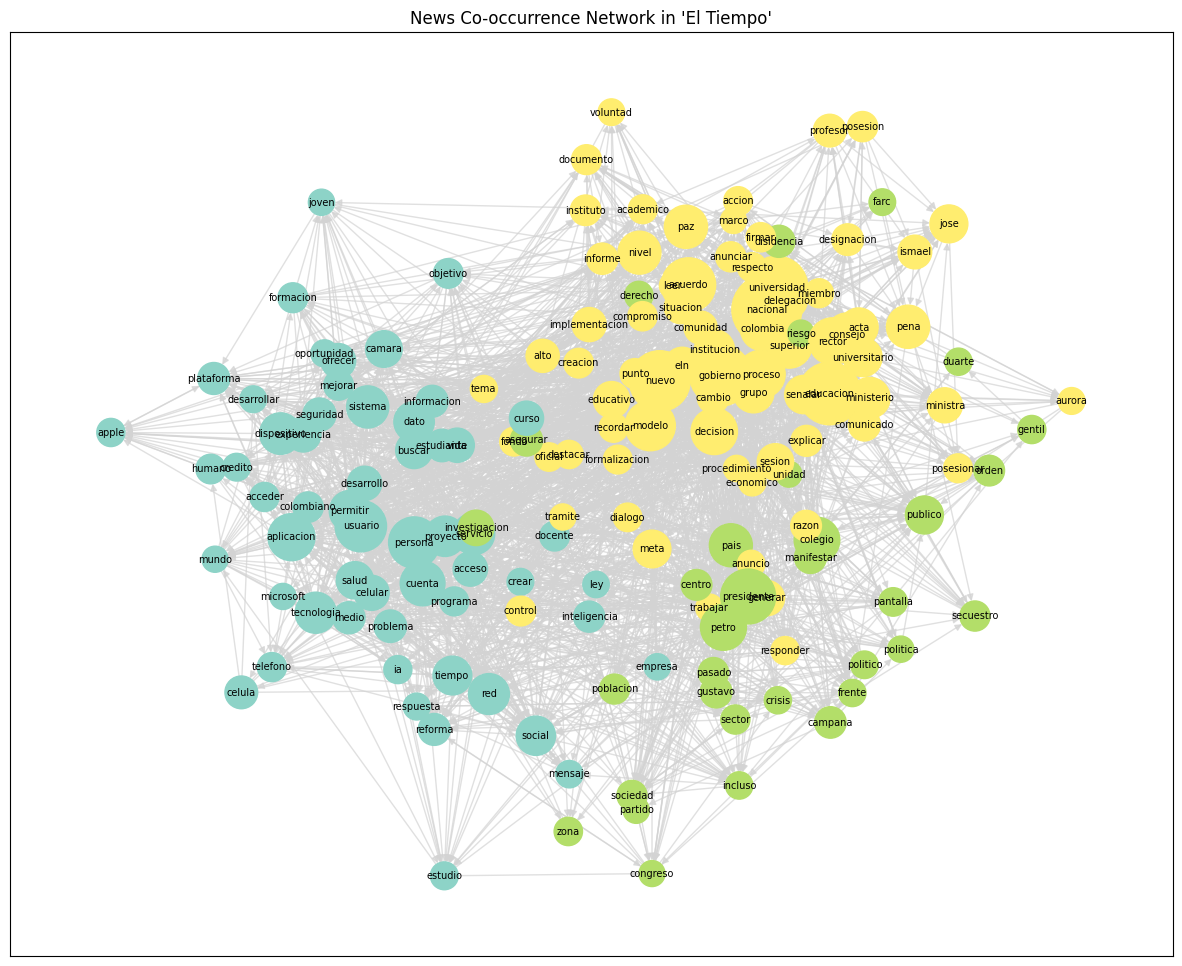

In [78]:
# Plot the subgraph with nodes sized proportionally to the sum of scores for each node
plt.figure(figsize=(15, 12))
pos = nx.spring_layout(subgraph,k=0.72, seed=10, iterations=350)
#pos = nx.kamada_kawai_layout(subgraph,scale=0.2)

community_pos = {}
community_counts = {}
for node, community in zip(subgraph.nodes(),node_colors):
    if community in community_pos:
        community_pos[community] += np.array(pos[node])
        community_counts[community] += 1
    else:
        community_pos[community] = np.array(pos[node])
        community_counts[community] = 1

# Average the positions to find the center
for community in community_pos:
    community_pos[community] /= community_counts[community]

center = community_pos[0]+community_pos[1]+community_pos[2]

rc =1
community_pos[0] += rc*normalize(community_pos[0]- center)
community_pos[1] += rc*normalize(community_pos[1]- center)
community_pos[2] += rc*normalize(community_pos[2]- center)

# Refine node positions to gravitate towards their community center
for node in pos:
    community = communities[node]
    pos[node] = 0.8 * np.array(pos[node]) + 0.2 * community_pos[community]
#pos = nx.spring_layout(subgraph, pos=pos,iterations=5)
#nx.draw(subgraph, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.Set3, with_labels=True)
nx.draw_networkx_edges(subgraph, pos, node_size=node_sizes,alpha=0.7, edge_color='lightgray')
nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.Set3)
nx.draw_networkx_labels(subgraph, pos, font_size=7)
plt.title("News Co-occurrence Network in 'El Tiempo'")

plt.show()


In [38]:
degree_centrality = nx.degree_centrality(G)

In [39]:
closeness_centrality = nx.closeness_centrality(G)

In [40]:
betweenness_centrality = nx.betweenness_centrality(G)

In [41]:
eigenvector_centrality = nx.eigenvector_centrality(G)

In [42]:
pagerank = nx.pagerank(G)

In [43]:
clustering_coefficient = nx.clustering(G)

In [44]:
network_metrics = pd.DataFrame({
    'Node': list(G.nodes()),
    'Degree Centrality': [degree_centrality[node] for node in G.nodes()],
    'Closeness Centrality': [closeness_centrality[node] for node in G.nodes()],
    'Betweenness Centrality': [betweenness_centrality[node] for node in G.nodes()],
    'Eigenvector Centrality': [eigenvector_centrality[node] for node in G.nodes()],
    'PageRank': [pagerank[node] for node in G.nodes()],
    'Clustering Coefficient': [clustering_coefficient[node] for node in G.nodes()]
})

In [45]:
network_metrics.mean(numeric_only=True)

Degree Centrality         0.003798
Closeness Centrality      0.260532
Betweenness Centrality    0.000520
Eigenvector Centrality    0.007577
PageRank                  0.000208
Clustering Coefficient    0.251331
dtype: float64

In [46]:
# Calculate top 5 nodes for each metric with their names and values
top_nodes_by_metric = pd.DataFrame()

for metric in network_metrics.columns[1:]:
    top_nodes_by_metric[f'Top Node for {metric}'] = [node for node in network_metrics.nlargest(10, metric)['Node']]
    top_nodes_by_metric[f'{metric} Value'] = [value for value in network_metrics.nlargest(10, metric)[metric]]

top_nodes_by_metric

,Top Node for Degree Centrality,Degree Centrality Value,Top Node for Closeness Centrality,Closeness Centrality Value,Top Node for Betweenness Centrality,Betweenness Centrality Value,Top Node for Eigenvector Centrality,Eigenvector Centrality Value,Top Node for PageRank,PageRank Value,Top Node for Clustering Coefficient,Clustering Coefficient Value
0,nacional,0.077868,nuevo,0.387163,nuevo,0.037435,nuevo,0.157835,nacional,0.005442,autorizado,1.000000
1,nuevo,0.075370,persona,0.378406,nacional,0.036565,gobierno,0.135690,gobierno,0.003883,humana,1.000000
2,usuario,0.070373,gobierno,0.377352,persona,0.034646,usuario,0.130137,universidad,0.003857,hepatitis,1.000000
3,gobierno,0.069332,nacional,0.375796,gobierno,0.031994,persona,0.128909,nuevo,0.003441,monitorear,1.000000
4,persona,0.069332,usuario,0.374191,usuario,0.030596,nacional,0.126563,usuario,0.003340,socialismo,0.900000
5,modelo,0.061628,aplicacion,0.371885,modelo,0.026421,aplicacion,0.121345,educacion,0.003225,binaria,0.900000
6,aplicacion,0.061004,pais,0.371298,dispositivo,0.025289,educacion,0.111019,persona,0.003071,centralizado,0.833333
7,dispositivo,0.055590,educacion,0.369333,aplicacion,0.025218,pais,0.102852,presidente,0.002972,dario,0.833333
8,presidente,0.054966,proceso,0.368055,pais,0.023058,dispositivo,0.101163,dispositivo,0.002809,disparidad,0.833333
9,universidad,0.053716,permitir,0.366606,acuerdo,0.021881,universidad,0.101048,aplicacion,0.002743,agroindustrial,0.833333


**Degree Centrality :**

In the context of a co-occurrence network over a newspaper, degree centrality could indicate the frequency of terms or topics appearing together within articles. A low degree centrality suggests that terms or topics do not frequently co-occur, or that the newspaper covers a wide range of diverse topics without strong associations between them.

**Closeness Centrality :**

Closeness centrality could reflect how interconnected the topics covered by the newspaper are. A high closeness centrality suggests that the topics discussed in the newspaper are closely related, with articles covering a wide range of topics but still interconnected through shared themes or subjects.

**Betweenness Centrality :**

Betweenness centrality indicates the extent to which certain topics or terms act as bridges or intermediaries between other topics in the newspaper. A low betweenness centrality suggests that there are not many topics or terms that play a significant role in connecting different themes or subjects within the newspaper's content.

**Eigenvector Centrality :**

Eigenvector centrality could represent the influence or importance of certain topics or terms within the newspaper's content. A low eigenvector centrality suggests that there are not many highly influential topics or terms that consistently appear together within articles.

**PageRank:**

PageRank measures the importance of topics or terms based on their connections to other important topics or terms within the newspaper's content. A low PageRank value indicates that there are not many topics or terms that are highly recommended or frequently referenced within articles.

**Clustering Coefficient :**

In the context of a co-occurrence network over a newspaper, a high clustering coefficient suggests that there are clusters or groups of topics that are frequently discussed together within articles. This could indicate that the newspaper tends to cover certain themes or subjects in depth, with articles related to those themes often appearing together.

### Build Education network

In [47]:
education_network = score_network_df[score_network_df['category']=='education'].groupby(['_from','to']).agg(score=('tfidf_score', 'sum')).reset_index()

In [48]:
education_network.sort_values('score', ascending=False).head(10)

,_from,to,score
11921,universidad,nacional,0.038953
7416,ministerio,educacion,0.019477
2409,consejo,superior,0.017854
6594,ismael,pena,0.017529
6648,jose,ismael,0.016555
11393,superior,universitario,0.016231
7444,ministra,educacion,0.012660
3954,educacion,superior,0.012659
10092,rector,universidad,0.012335
1162,aurora,vergara,0.011686


In [49]:
scaler = MinMaxScaler()

education_network['normalized_score'] = scaler.fit_transform(education_network[['score']])
education_network = education_network[education_network['_from'] != education_network['to'] ]

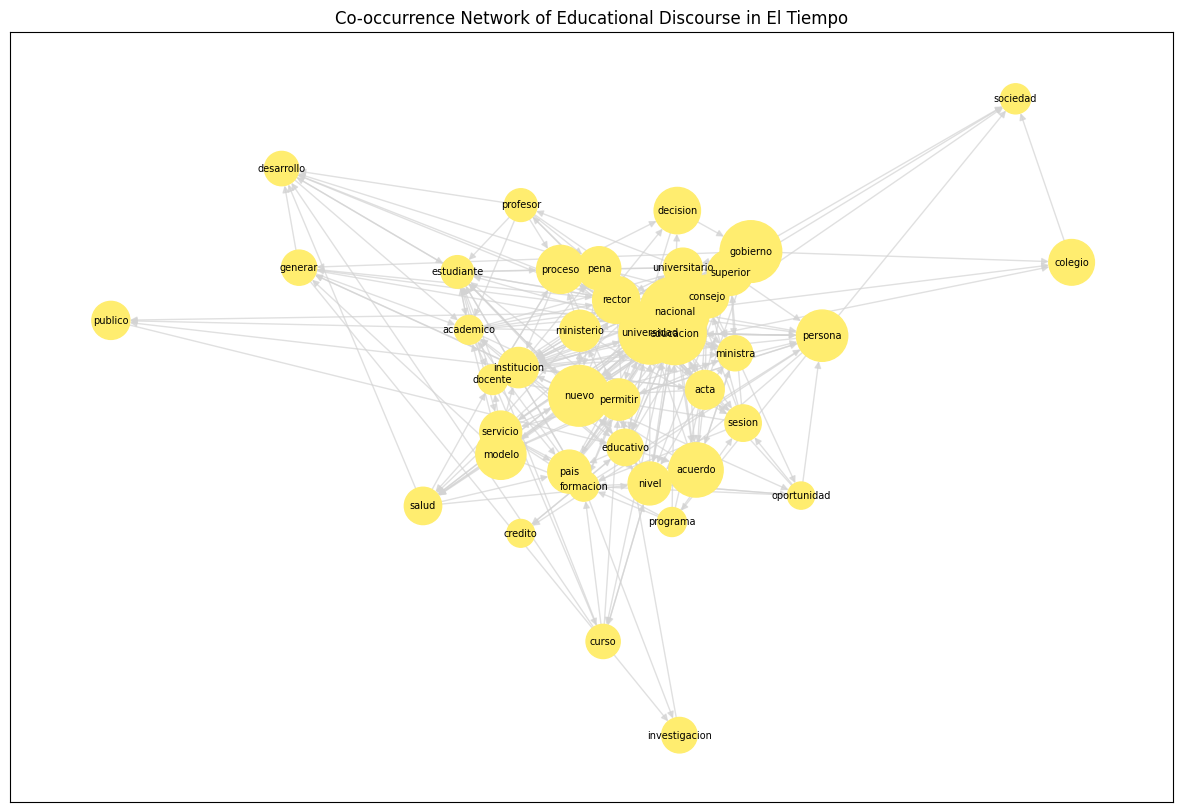

In [50]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

# Add edges from the DataFrame with weights
for _, row in education_network.iterrows():
    G.add_edge(row['_from'], row['to'], weight=row['normalized_score'])

# Assuming G is your directed graph
plt.figure(figsize=(15, 10))

# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

# Filter nodes with degree centrality >= 0.03 (at least 3)
filtered_nodes = [node for node, centrality in degree_centrality.items() if centrality >= 0.03]

# Generate subgraph containing only filtered nodes
subgraph = G.subgraph(filtered_nodes)
subgraph_node_scores = {node: node_scores_dict.get(node, 0) for node in subgraph.nodes()}

# Visualize the subgraph
pos = nx.spring_layout(subgraph, k=0.2, seed=8, iterations=100)
node_sizes = [subgraph_node_scores[node] * 800 + 5 for node in subgraph.nodes()]

nx.draw_networkx_edges(subgraph, pos, node_size=node_sizes, alpha=0.7, edge_color='lightgray')
nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes,  node_color='#FFED6F')
nx.draw_networkx_labels(subgraph, pos, font_size=7)
plt.title("Co-occurrence Network of Educational Discourse in El Tiempo")

plt.show()


In [51]:
network_metrics = pd.DataFrame({
    'Node': list(G.nodes()),
    'Degree Centrality': [degree_centrality[node] for node in G.nodes()],
    'Closeness Centrality': [closeness_centrality[node] for node in G.nodes()],
    'Betweenness Centrality': [betweenness_centrality[node] for node in G.nodes()],
    'Eigenvector Centrality': [eigenvector_centrality[node] for node in G.nodes()],
    'PageRank': [pagerank[node] for node in G.nodes()],
    'Clustering Coefficient': [clustering_coefficient[node] for node in G.nodes()]
})

In [52]:
network_metrics.mean(numeric_only=True)

Degree Centrality         0.006795
Closeness Centrality      0.276254
Betweenness Centrality    0.001087
Eigenvector Centrality    0.012730
PageRank                  0.000336
Clustering Coefficient    0.188138
dtype: float64

In [53]:
# Calculate top 5 nodes for each metric with their names and values
top_nodes_by_metric = pd.DataFrame()

for metric in network_metrics.columns[1:]:
    top_nodes_by_metric[f'Top Node for {metric}'] = [node for node in network_metrics.nlargest(10, metric)['Node']]
    top_nodes_by_metric[f'{metric} Value'] = [value for value in network_metrics.nlargest(10, metric)[metric]]

top_nodes_by_metric

,Top Node for Degree Centrality,Degree Centrality Value,Top Node for Closeness Centrality,Closeness Centrality Value,Top Node for Betweenness Centrality,Betweenness Centrality Value,Top Node for Eigenvector Centrality,Eigenvector Centrality Value,Top Node for PageRank,PageRank Value,Top Node for Clustering Coefficient,Clustering Coefficient Value
0,universidad,0.115123,nuevo,0.387163,nuevo,0.037435,nuevo,0.157835,nacional,0.005442,humana,1.000000
1,educacion,0.114076,persona,0.378406,nacional,0.036565,gobierno,0.135690,gobierno,0.003883,agroindustrial,0.833333
2,nacional,0.099948,gobierno,0.377352,persona,0.034646,usuario,0.130137,universidad,0.003857,negocios,0.777778
3,nuevo,0.087389,nacional,0.375796,gobierno,0.031994,persona,0.128909,nuevo,0.003441,apilabl,0.769231
4,estudiante,0.070644,usuario,0.374191,usuario,0.030596,nacional,0.126563,usuario,0.003340,moto,0.714286
5,persona,0.068027,aplicacion,0.371885,modelo,0.026421,aplicacion,0.121345,educacion,0.003225,acerca,0.692308
6,educativo,0.064364,pais,0.371298,dispositivo,0.025289,educacion,0.111019,persona,0.003071,gobernacion,0.678571
7,institucion,0.061224,educacion,0.369333,aplicacion,0.025218,pais,0.102852,presidente,0.002972,bilinguismo,0.666667
8,superior,0.060178,proceso,0.368055,pais,0.023058,dispositivo,0.101163,dispositivo,0.002809,asesores,0.666667
9,acta,0.059131,permitir,0.366606,acuerdo,0.021881,universidad,0.101048,aplicacion,0.002743,certificador,0.666667


### Build Tech network

In [54]:
tech_network = score_network_df[score_network_df['category']=='tech'].groupby(['_from','to']).agg(score=('tfidf_score', 'sum')).reset_index()

In [55]:
tech_network.sort_values('score', ascending=False).head(10)

,_from,to,score
13825,red,social,0.014879
8785,inteligencia,artificial,0.010964
15049,sistema,operativo,0.007831
9850,map,view,0.006265
6727,experiencia,usuario,0.006004
15680,telefono,inteligente,0.005482
2610,celular,red,0.005221
12180,permitir,usuario,0.004699
11755,pagina,web,0.004699
14481,salud,mental,0.004699


In [56]:
scaler = MinMaxScaler()

tech_network['normalized_score'] = scaler.fit_transform(tech_network[['score']])
tech_network = tech_network[tech_network['_from'] != tech_network['to'] ]

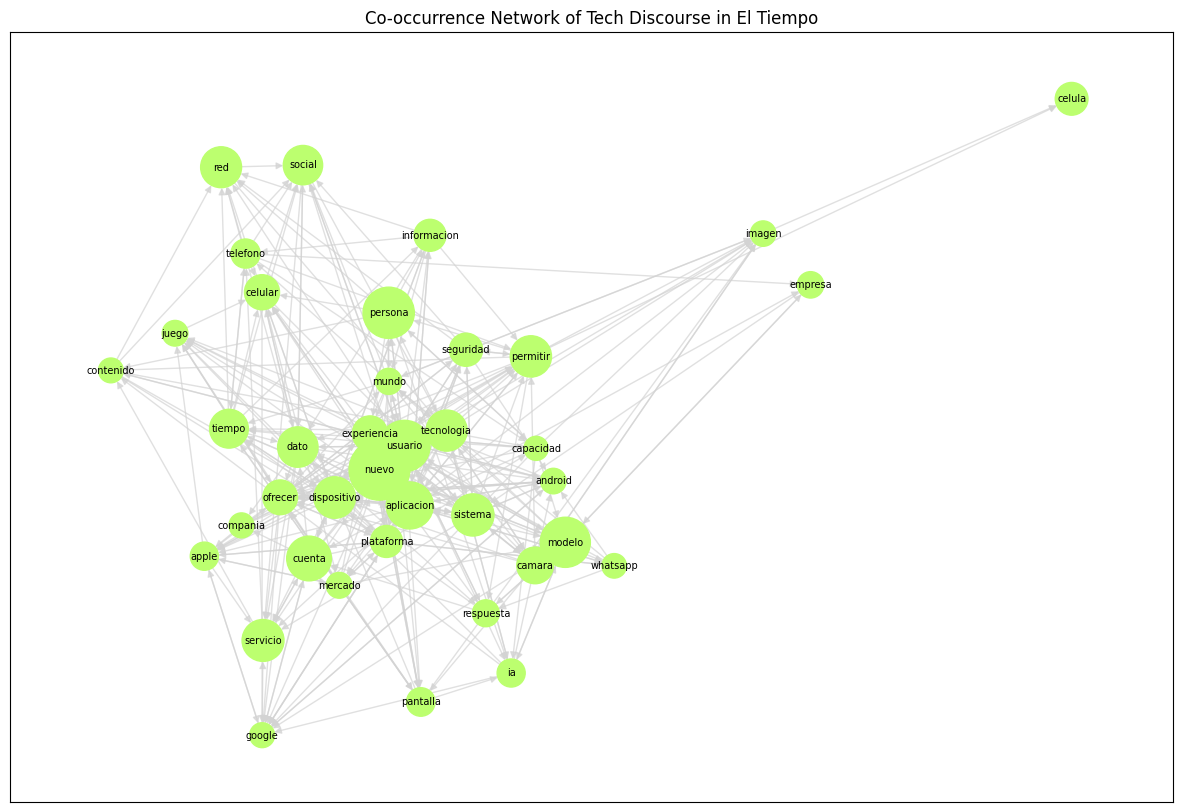

In [57]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

# Add edges from the DataFrame with weights
for _, row in tech_network.iterrows():
    G.add_edge(row['_from'], row['to'], weight=row['normalized_score'])

# Assuming G is your directed graph
plt.figure(figsize=(15, 10))

# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

# Filter nodes with degree centrality >= 0.03 (at least 3)
filtered_nodes = [node for node, centrality in degree_centrality.items() if centrality >= 0.03]

# Generate subgraph containing only filtered nodes
subgraph = G.subgraph(filtered_nodes)
subgraph_node_scores = {node: node_scores_dict.get(node, 0) for node in subgraph.nodes()}

# Visualize the subgraph
pos = nx.spring_layout(subgraph, k=0.2, seed=8, iterations=100)
node_sizes = [subgraph_node_scores[node] * 800 + 5 for node in subgraph.nodes()]

nx.draw_networkx_edges(subgraph, pos, node_size=node_sizes, alpha=0.7, edge_color='lightgray')
nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes,  node_color='#BCFF6F')
nx.draw_networkx_labels(subgraph, pos, font_size=7)
plt.title("Co-occurrence Network of Tech Discourse in El Tiempo")
plt.show()


In [58]:
network_metrics = pd.DataFrame({
    'Node': list(G.nodes()),
    'Degree Centrality': [degree_centrality[node] for node in G.nodes()],
    'Closeness Centrality': [closeness_centrality[node] for node in G.nodes()],
    'Betweenness Centrality': [betweenness_centrality[node] for node in G.nodes()],
    'Eigenvector Centrality': [eigenvector_centrality[node] for node in G.nodes()],
    'PageRank': [pagerank[node] for node in G.nodes()],
    'Clustering Coefficient': [clustering_coefficient[node] for node in G.nodes()]
})

In [59]:
network_metrics.mean(numeric_only=True)

Degree Centrality         0.005251
Closeness Centrality      0.267908
Betweenness Centrality    0.000806
Eigenvector Centrality    0.010032
PageRank                  0.000253
Clustering Coefficient    0.222924
dtype: float64

In [60]:
# Calculate top 5 nodes for each metric with their names and values
top_nodes_by_metric = pd.DataFrame()

for metric in network_metrics.columns[1:]:
    top_nodes_by_metric[f'Top Node for {metric}'] = [node for node in network_metrics.nlargest(10, metric)['Node']]
    top_nodes_by_metric[f'{metric} Value'] = [value for value in network_metrics.nlargest(10, metric)[metric]]

top_nodes_by_metric

,Top Node for Degree Centrality,Degree Centrality Value,Top Node for Closeness Centrality,Closeness Centrality Value,Top Node for Betweenness Centrality,Betweenness Centrality Value,Top Node for Eigenvector Centrality,Eigenvector Centrality Value,Top Node for PageRank,PageRank Value,Top Node for Clustering Coefficient,Clustering Coefficient Value
0,usuario,0.130043,nuevo,0.387163,nuevo,0.037435,nuevo,0.157835,nacional,0.005442,autorizado,1.000000
1,aplicacion,0.104191,persona,0.378406,nacional,0.036565,usuario,0.130137,universidad,0.003857,hepatitis,1.000000
2,dispositivo,0.091265,nacional,0.375796,persona,0.034646,persona,0.128909,nuevo,0.003441,monitorear,1.000000
3,modelo,0.081473,usuario,0.374191,usuario,0.030596,nacional,0.126563,usuario,0.003340,binaria,0.900000
4,tecnologia,0.075206,aplicacion,0.371885,modelo,0.026421,aplicacion,0.121345,educacion,0.003225,centralizado,0.833333
5,dato,0.069722,pais,0.371298,dispositivo,0.025289,educacion,0.111019,persona,0.003071,dario,0.833333
6,nuevo,0.068939,educacion,0.369333,aplicacion,0.025218,pais,0.102852,dispositivo,0.002809,delantero,0.800000
7,plataforma,0.061496,proceso,0.368055,pais,0.023058,dispositivo,0.101163,aplicacion,0.002743,organica,0.769231
8,celular,0.054837,permitir,0.366606,acuerdo,0.021881,universidad,0.101048,colombia,0.002726,figurar,0.750000
9,cuenta,0.054446,servicio,0.365466,permitir,0.020494,proceso,0.100785,social,0.002632,asigno,0.722222


### Build Politic network

In [61]:
politic_network = score_network_df[score_network_df['category']=='politic'].groupby(['_from','to']).agg(score=('tfidf_score', 'sum')).reset_index()

In [62]:
politic_network.sort_values('score', ascending=False).head(10)

,_from,to,score
11479,presidente,petro,0.017138
6944,gustavo,petro,0.016857
11443,presidente,gustavo,0.012081
214,acuerdo,paz,0.009272
6660,gobierno,nacional,0.007586
3936,delegacion,gobierno,0.007586
4298,desplazamiento,forzado,0.007585
12334,red,social,0.006743
10071,pacto,historico,0.006743
7677,instituto,kroc,0.006743


In [63]:
scaler = MinMaxScaler()

politic_network['normalized_score'] = scaler.fit_transform(politic_network[['score']])
politic_network = politic_network[politic_network['_from'] != politic_network['to'] ]

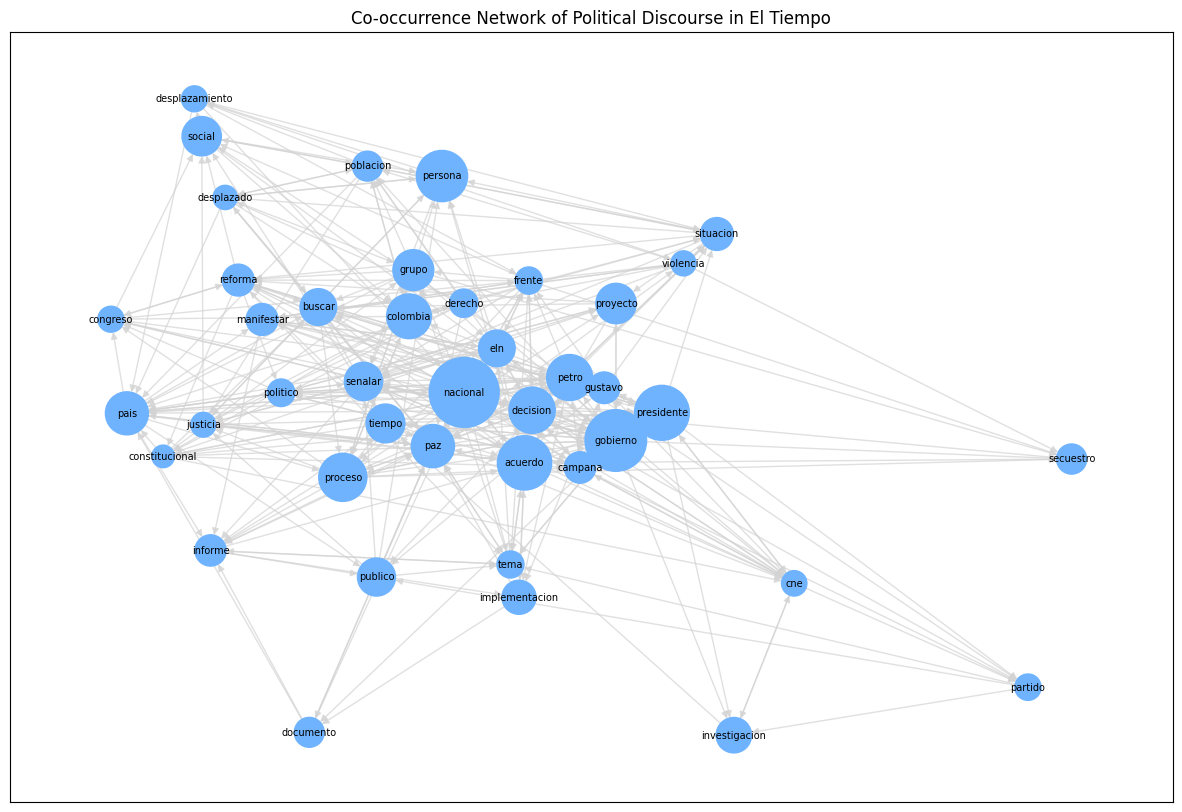

In [64]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

# Add edges from the DataFrame with weights
for _, row in politic_network.iterrows():
    G.add_edge(row['_from'], row['to'], weight=row['normalized_score'])

# Assuming G is your directed graph
plt.figure(figsize=(15, 10))

# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

# Filter nodes with degree centrality >= 0.03 (at least 3)
filtered_nodes = [node for node, centrality in degree_centrality.items() if centrality >= 0.03]

# Generate subgraph containing only filtered nodes
subgraph = G.subgraph(filtered_nodes)
subgraph_node_scores = {node: node_scores_dict.get(node, 0) for node in subgraph.nodes()}

# Visualize the subgraph
pos = nx.spring_layout(subgraph, k=0.3, seed=9, iterations=100)
node_sizes = [subgraph_node_scores[node] * 800 + 5 for node in subgraph.nodes()]

nx.draw_networkx_edges(subgraph, pos, node_size=node_sizes, alpha=0.7, edge_color='lightgray')
nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes,  node_color='#6FB3FF')
nx.draw_networkx_labels(subgraph, pos, font_size=7)
plt.title("Co-occurrence Network of Political Discourse in El Tiempo")
plt.show()


In [65]:
network_metrics = pd.DataFrame({
    'Node': list(G.nodes()),
    'Degree Centrality': [degree_centrality[node] for node in G.nodes()],
    'Closeness Centrality': [closeness_centrality[node] for node in G.nodes()],
    'Betweenness Centrality': [betweenness_centrality[node] for node in G.nodes()],
    'Eigenvector Centrality': [eigenvector_centrality[node] for node in G.nodes()],
    'PageRank': [pagerank[node] for node in G.nodes()],
    'Clustering Coefficient': [clustering_coefficient[node] for node in G.nodes()]
})

In [66]:
network_metrics.mean(numeric_only=True)

Degree Centrality         0.005821
Closeness Centrality      0.270438
Betweenness Centrality    0.000885
Eigenvector Centrality    0.010791
PageRank                  0.000283
Clustering Coefficient    0.204203
dtype: float64

In [67]:
# Calculate top 5 nodes for each metric with their names and values
top_nodes_by_metric = pd.DataFrame()

for metric in network_metrics.columns[1:]:
    top_nodes_by_metric[f'Top Node for {metric}'] = [node for node in network_metrics.nlargest(10, metric)['Node']]
    top_nodes_by_metric[f'{metric} Value'] = [value for value in network_metrics.nlargest(10, metric)[metric]]

top_nodes_by_metric

,Top Node for Degree Centrality,Degree Centrality Value,Top Node for Closeness Centrality,Closeness Centrality Value,Top Node for Betweenness Centrality,Betweenness Centrality Value,Top Node for Eigenvector Centrality,Eigenvector Centrality Value,Top Node for PageRank,PageRank Value,Top Node for Clustering Coefficient,Clustering Coefficient Value
0,gobierno,0.122296,nuevo,0.387163,nuevo,0.037435,nuevo,0.157835,nacional,0.005442,socialismo,0.900000
1,presidente,0.104636,persona,0.378406,nacional,0.036565,gobierno,0.135690,gobierno,0.003883,disparidad,0.833333
2,petro,0.094923,gobierno,0.377352,persona,0.034646,persona,0.128909,universidad,0.003857,exconsejera,0.769231
3,nacional,0.086976,nacional,0.375796,gobierno,0.031994,nacional,0.126563,nuevo,0.003441,regiones,0.769231
4,paz,0.078146,aplicacion,0.371885,modelo,0.026421,aplicacion,0.121345,educacion,0.003225,disuado,0.714286
5,acuerdo,0.069316,pais,0.371298,aplicacion,0.025218,educacion,0.111019,persona,0.003071,lar,0.678571
6,decision,0.060486,educacion,0.369333,pais,0.023058,pais,0.102852,presidente,0.002972,lleras,0.666667
7,pais,0.054746,proceso,0.368055,acuerdo,0.021881,universidad,0.101048,aplicacion,0.002743,pumarejo,0.666667
8,reforma,0.054305,permitir,0.366606,presidente,0.021868,proceso,0.100785,colombia,0.002726,registrado,0.666667
9,colombia,0.052980,servicio,0.365466,permitir,0.020494,acuerdo,0.097488,social,0.002632,bomba,0.666667


### Build Bag of Words
* By frequency
* By TF-IDF

In [68]:
word_frequencies

NameError: name 'word_frequencies' is not defined

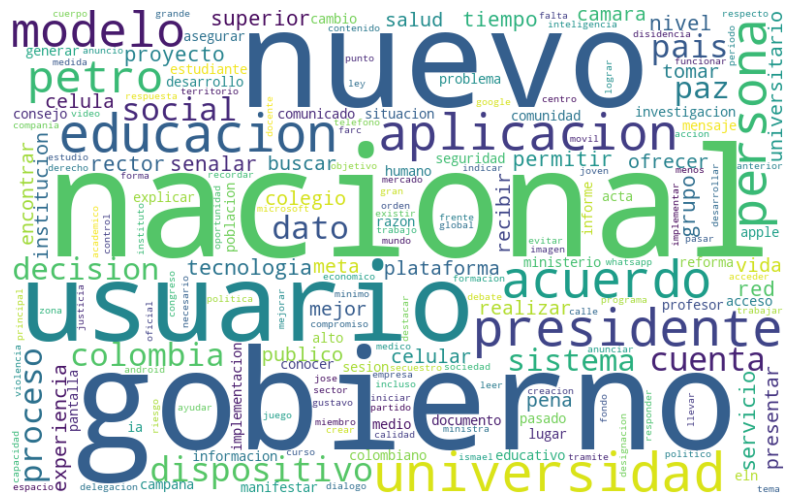

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import re

# Example raw text
raw_text = ' '.join(documents_clean)

# Function to preprocess and compute word frequencies
def calculate_frequencies(text):
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Convert text to lowercase
    text = text.lower()
    # Tokenize the text into words
    words = text.split()
    # Calculate frequencies
    frequencies = Counter(words)
    return frequencies

# Calculate frequencies
word_frequencies = calculate_frequencies(raw_text)

# Generate word cloud
wc = WordCloud(width=800, height=500, background_color='white').generate_from_frequencies(word_frequencies)

# Display the word cloud
plt.figure(figsize=(10, 7))  # Size of the plot
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.show()


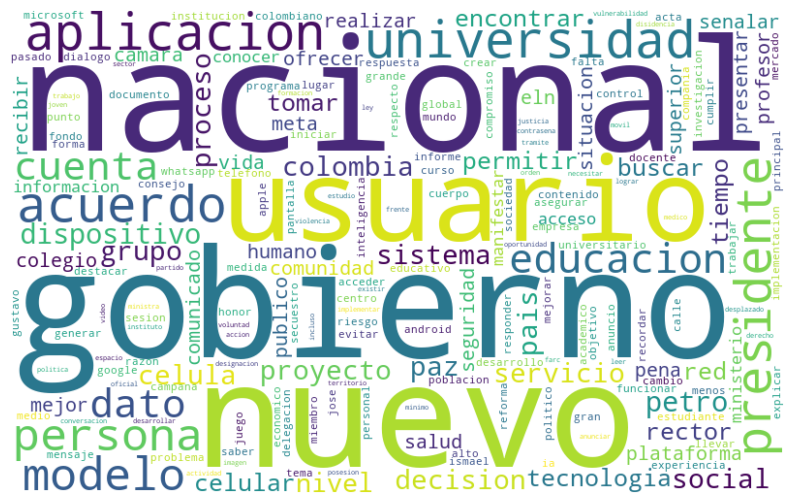

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the documents
tfidf_matrix = tfidf_vectorizer.fit_transform(documents_clean)

# Get feature names and tf-idf array
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.toarray()

# Calculate total tf-idf score for each word
word_tfidf_scores = np.sum(tfidf_scores, axis=0)
word_tfidf_dict = dict(zip(feature_names, word_tfidf_scores))

# Generate word cloud
wc = WordCloud(width=800, height=500, background_color='white').generate_from_frequencies(word_tfidf_dict)

# Display the word cloud
plt.figure(figsize=(10, 7))  # Size of the plot
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.show()